In [1]:
# ==============================================================================
# SCRIPT -- AlexNet with a Memory-Safe Data Pipeline
# ==============================================================================
# This script contains all the corrected code to:
# 1. Load CIFAR-10 and create a memory-safe tf.data pipeline for resizing.
# 2. Build the Keras model of the AlexNet architecture.
# 3. Train the model using the efficient pipeline.
# 4. Evaluate and plot the results.
#

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

print("TensorFlow Version:", tf.__version__)


2025-09-30 07:52:34.084452: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759218754.451692      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759218754.555147      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow Version: 2.18.0


In [2]:
## --------------------------------------
## 1. DATA LOADING AND PARAMETERS
## --------------------------------------
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values and one-hot encode the labels
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Define parameters
NUM_CLASSES = 10
IMG_SIZE = 224
BATCH_SIZE = 128
L2_LAMBDA = 0.0005 # Weight decay


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
## --------------------------------------
## 2. IMPROVED DATA PIPELINE WITH AUGMENTATION
## --------------------------------------
# Create a sequential model for data augmentation
data_augmentation = Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Function to resize images
def resize_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

# Function to apply augmentation to the training set
def augment_and_resize(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = data_augmentation(tf.expand_dims(image, 0), training=True)[0]
    return image, label

# Create efficient tf.data pipelines
print("Building memory-safe data pipelines with augmentation...")
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Apply shuffling and augmentation to the training set
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.map(augment_and_resize, num_parallel_calls=tf.data.AUTOTUNE)

# Only apply resizing to the test set
test_dataset = test_dataset.map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch both datasets for performance
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
print("Data pipelines created successfully.")



I0000 00:00:1759218779.943116      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759218779.943819      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Building memory-safe data pipelines with augmentation...
Data pipelines created successfully.


In [4]:
## --------------------------------------
## 3. MULTI-GPU SETUP, MODEL DEFINITION AND COMPILATION
## --------------------------------------

# 1. Create a MirroredStrategy to use all available GPUs
strategy = tf.distribute.MirroredStrategy()
print(f'Number of devices: {strategy.num_replicas_in_sync}')

# 2. Define AND compile the model inside the strategy's scope
with strategy.scope():
    # --- Model Definition ---
    model = Sequential([
        Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu',
               input_shape=(224, 224, 3), kernel_regularizer=l2(L2_LAMBDA)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        Conv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu', kernel_regularizer=l2(L2_LAMBDA)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(L2_LAMBDA)),
        Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(L2_LAMBDA)),
        Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(L2_LAMBDA)),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        Flatten(),
        Dense(4096, activation='relu', kernel_regularizer=l2(L2_LAMBDA)),
        Dropout(0.5),
        Dense(4096, activation='relu', kernel_regularizer=l2(L2_LAMBDA)),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    
    # --- Model Compilation with stable learning rate ---
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()



Number of devices: 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 54, 54, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 26, 26, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    26,218,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,789,386 (178.49 MB)

 Trainable params: 46,788,682 (178.48 MB)

 Non-trainable params: 704 (2.75 KB)

In [5]:
## --------------------------------------
## 4. TRAINING THE MODEL
## --------------------------------------
# Callbacks to stop training when performance worsens and to reduce the learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

EPOCHS = 100

print("\nStarting model training on multiple GPUs...")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=test_dataset,
    callbacks=[early_stopping, reduce_lr]
)
print("Model training complete.")




Starting model training on multiple GPUs...
Epoch 1/100


I0000 00:00:1759218794.728912      63 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1759218794.778591      62 cuda_dnn.cc:529] Loaded cuDNN version 90300


391/391 ━━━━━━━━━━━━━━━━━━━━ 233s 559ms/step - accuracy: nan - loss: nan - val_accuracy: 0.2552 - val_loss: 5.8087 - learning_rate: 1.0000e-04
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 219s 559ms/step - accuracy: nan - loss: nan - val_accuracy: 0.5852 - val_loss: 3.8615 - learning_rate: 1.0000e-04
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 219s 559ms/step - accuracy: nan - loss: nan - val_accuracy: 0.6959 - val_loss: 3.0414 - learning_rate: 1.0000e-04
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 219s 559ms/step - accuracy: nan - loss: nan - val_accuracy: 0.6860 - val_loss: 2.6492 - learning_rate: 1.0000e-04
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 220s 559ms/step - accuracy: nan - loss: nan - val_accuracy: 0.6390 - val_loss: 2.4970 - learning_rate: 1.0000e-04
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 219s 558ms/step - accuracy: nan - loss: nan - val_accuracy: 0.7129 - val_loss: 2.0626 - learning_rate: 1.0000e-04
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 220s 560ms/step - accuracy: nan - loss: n


Evaluating model on the test set...
79/79 - 4s - 52ms/step - accuracy: 0.9057 - loss: 0.6873

Test Loss: 0.6873
Test Accuracy: 90.57%

Plotting training history...


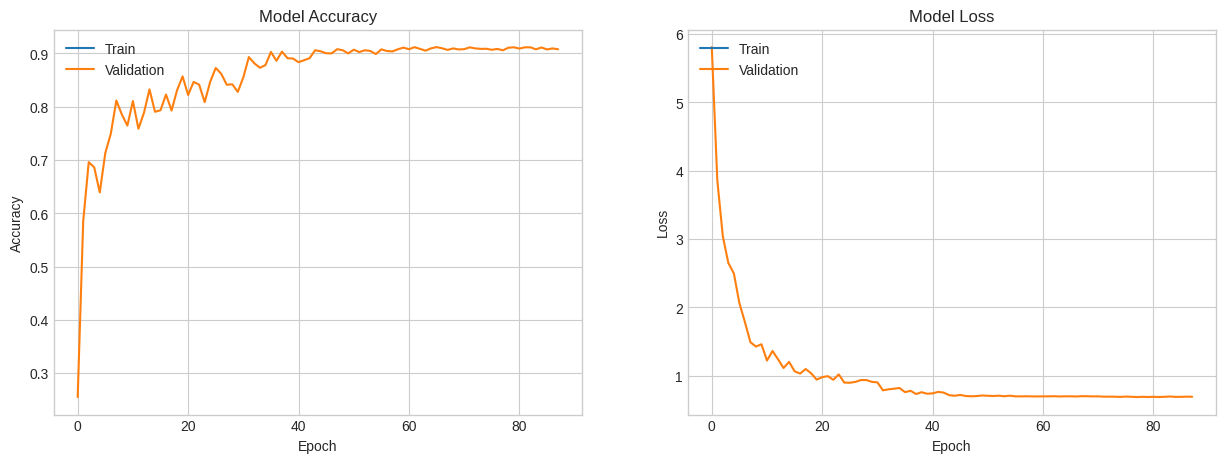

Script finished.


In [6]:
## --------------------------------------
## 5. EVALUATION AND PLOTTING
## --------------------------------------
print("\nEvaluating model on the test set...")
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=2)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

print("\nPlotting training history...")
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.show()
print("Script finished.")

